In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Packages
import numpy   as np
import pandas  as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# <a id='0'> Content
- <a href='#d'> PCA
- <a href='#c'> Clustering

## <a id='d'> Dimensionality reduction: PCA

### Applying PCA to the cancer dataset for visualization
The Breast cancer data set from Scikit-Learn.

In [2]:
# 0: malignant 212;  1: benign 357
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(cancer.keys())
cancer.data.shape

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


(569, 30)

Visualize all 30 features all at once is overwhelming.

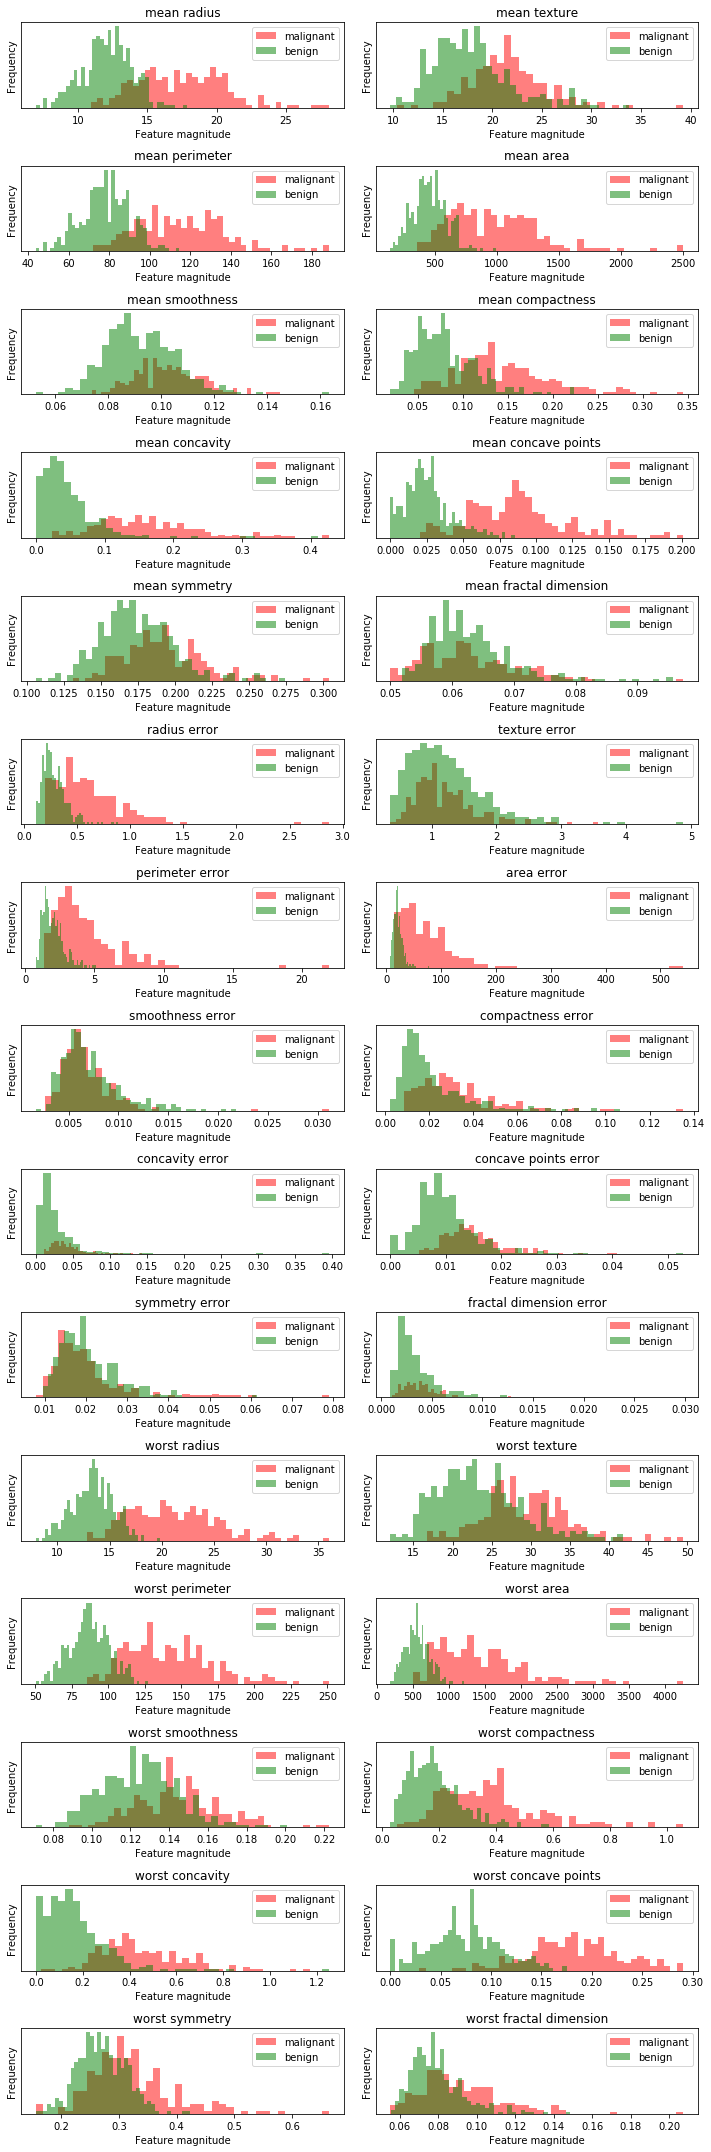

In [21]:
malignant = cancer.data[cancer.target == 0]
benign    = cancer.data[cancer.target == 1]

fig, axes = plt.subplots(15, 2, figsize=(10, 30))
ax = axes.ravel() # nice trick for 1-dim access

for i in range(30):    
    ax[i].hist(malignant[:, i], bins=40, color='r', alpha=.5)
    ax[i].hist(benign[:, i],    bins=40, color='g', alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(()) # nice trick to remove tick labels
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

Let's apply PCA to reduce the dimensions. <br>
First we need to scale the features to have mean 0 and variance 1. This scaling is essential because otherwise the found principal components will be skewed towards features with large magnitude, not large dispersion.

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cancer.data)

In [52]:
from sklearn.decomposition import PCA

# keep the first two principal components of the data
pca = PCA(n_components=2)

# fit PCA model to breast cancer data
#pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.fit_transform(X_scaled)

print("Original data shape: {}".format(str(X_scaled.shape)))
print("Reduced  data shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced  shape: (569, 2)


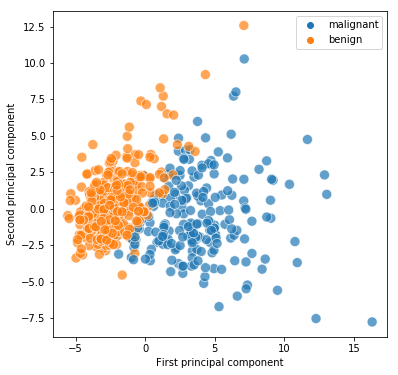

In [54]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(6, 6))
sns.scatterplot(X_pca[:,0], X_pca[:,1], 
                hue=cancer.target_names[cancer.target],
                s=100,alpha=0.7);

plt.legend(loc="best")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

In [55]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


Text(0,0.5,'Principal components')

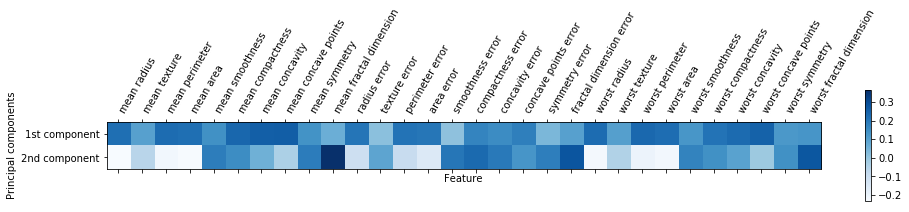

In [60]:
plt.figure(figsize=(16,2))
plt.matshow(pca.components_, cmap='Blues', fignum=1) # Note: tricky to set figure size for matshow()

plt.yticks([0, 1], ["1st component", "2nd component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
           cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

## <a id='c'> Clustering
- <a href='#0'> Back to TOC

### k-Means clustering

#### Iris data <br>

Visualizing the data

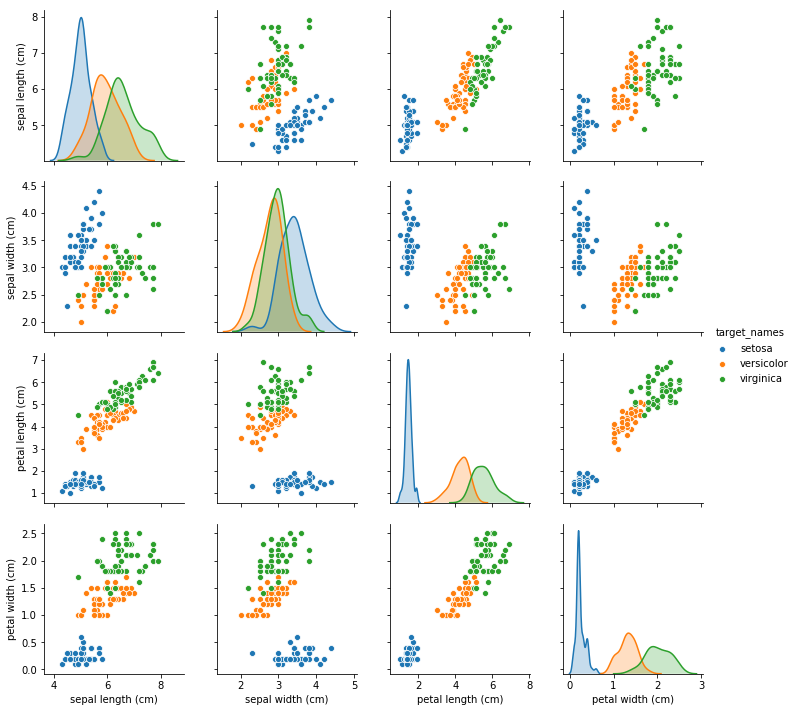

In [63]:
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target_names'] = data.target_names[data.target]
sns.pairplot(df, hue='target_names');

#### How to choose the optimal number of clusters for KMeans?

#### Using Sihouette Score
For a given clustered scheme, each data point can have a Sihouette score based on how well it belongs to its own cluster. The score is between -1 and 1, the larger the score, the better the clustering. A single score can be averaged over all data points, and can be used to help choosing the right number of clusters.

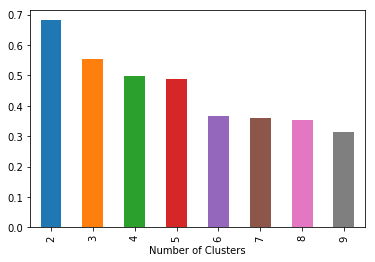

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X = df.drop('target_names', axis=1)
scores = {}
for k in range(2, 10):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)

    labels = k_means.labels_
    score      = silhouette_score(X,   labels)
    #all_scores = silhouette_samples(X, labels)
    scores[k] = score
pd.Series(scores).plot.bar()
plt.xlabel('Number of Clusters');

#### Using Elbow curve
Percentage of variance explained vs. Number of clusters

In [68]:
from scipy.spatial.distance import cdist, pdist

X = df.drop('target_names', axis=1)
K = range(1,8)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [km.cluster_centers_ for km in KM]

# distance of all data points to all centroids in all K clustering schemes
D_k = [cdist(X, centrds, 'euclidean') for centrds in centroids]
len(D_k) # 7

7

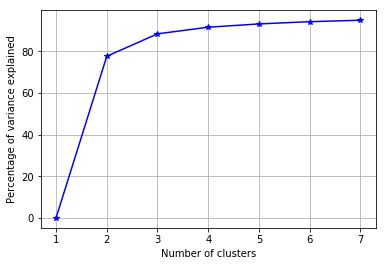

In [8]:
# # cluster indices for each data point
# cIdx = [np.argmin(D,axis=1) for D in D_k] # [km.labels_ for km in KM]

# distance to its own cluster centroid for all data points
dist = [np.min(D,axis=1) for D in D_k]

avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# Total with-in sum of square
wcss = [sum(d**2) for d in dist]

tss = sum(pdist(X)**2)/X.shape[0]
# between-cluster SS
bss = tss - wcss

# elbow curve - percentage of variance explained
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained');

### PCA

Text(0,0.5,'Explained Var')

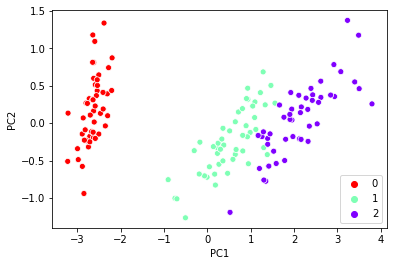

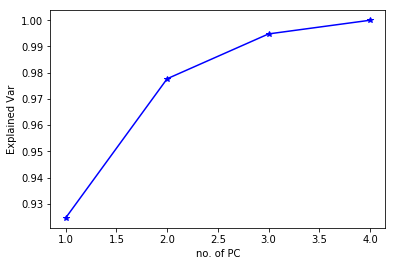

In [9]:
from sklearn.decomposition import PCA

data = load_iris()    
X = data.data
y = data.target

pca = PCA(n_components=4)
X_pc = pca.fit_transform(X)
var = pca.explained_variance_ratio_
var_cumulative = [sum(var[:i+1]) for i in range(len(var))]
#print(var_cumulative)
#plt.scatter(X_pc[:,0], X_pc[:,1], c=y, cmap='rainbow')
sns.scatterplot(X_pc[:,0], X_pc[:,1], y, palette='rainbow_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
pca_df = pd.DataFrame(pca.components_, columns=data.feature_names)
pca_df['explained_var'] = pca.explained_variance_ratio_
pd.set_option('precision', 2)
pca_df

plt.figure().add_subplot()
plt.plot(list(range(1,5)), var_cumulative, 'b*-')
plt.xlabel('no. of PC')
plt.ylabel('Explained Var')

In [10]:
k_means.labels_, data.target

(array([4, 0, 0, 0, 4, 4, 0, 4, 0, 0, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4,
        0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 0, 0, 4,
        4, 0, 4, 0, 4, 0, 7, 7, 7, 2, 7, 8, 7, 2, 7, 2, 2, 8, 2, 8, 2, 7,
        8, 8, 8, 2, 3, 8, 3, 8, 7, 7, 7, 7, 8, 2, 2, 2, 8, 3, 8, 8, 7, 8,
        8, 2, 8, 8, 8, 2, 8, 8, 8, 8, 2, 8, 6, 3, 1, 6, 6, 5, 8, 1, 1, 5,
        6, 3, 6, 3, 3, 6, 6, 5, 5, 3, 6, 3, 5, 3, 6, 1, 3, 3, 6, 1, 1, 5,
        6, 3, 3, 5, 6, 6, 3, 6, 6, 6, 3, 6, 6, 6, 3, 6, 6, 3], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 

##### Failure cases of k-Means

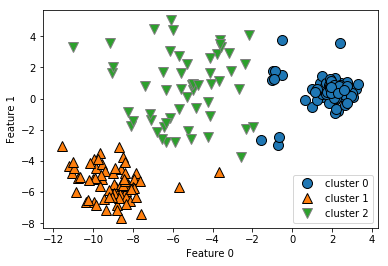

In [16]:
import mglearn
from sklearn.datasets import make_blobs
X_varied, y_varied = make_blobs(n_samples=200,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=170)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X_varied)

mglearn.discrete_scatter(X_varied[:, 0], X_varied[:, 1], y_pred)
plt.legend(["cluster 0", "cluster 1", "cluster 2"], loc='best')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

Text(0,0.5,'Feature 1')

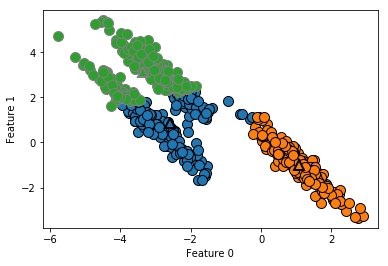

In [17]:
# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

# cluster the data into three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# plot the cluster assignments and cluster centers
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2],
    markers='^', markeredgewidth=2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0,0.5,'Feature 1')

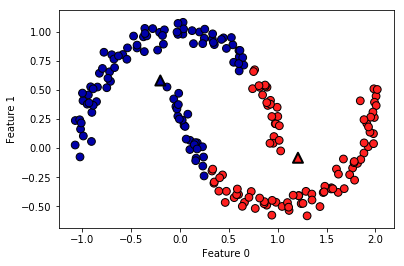

In [18]:
# generate synthetic two_moons data (with less noise this time)
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=mglearn.cm2, s=60, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2,
            edgecolor='k')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##### Hierarchical Clustering and Dendrograms

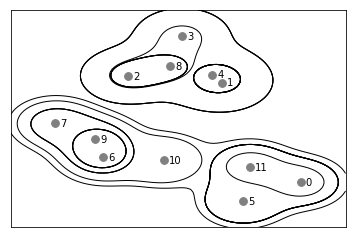

In [25]:
mglearn.plots.plot_agglomerative()

Text(0,0.5,'Cluster distance')

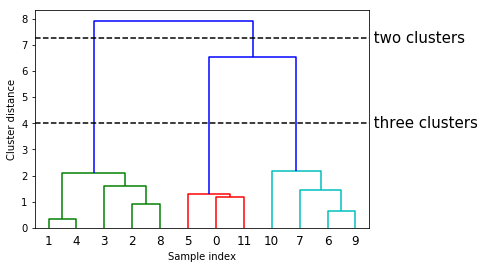

In [26]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

X, y = make_blobs(random_state=0, n_samples=12)
# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

#### DBSCAN

In [27]:
from sklearn.cluster import DBSCAN
X, y = make_blobs(random_state=0, n_samples=12)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:\n{}".format(clusters))

Cluster memberships:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


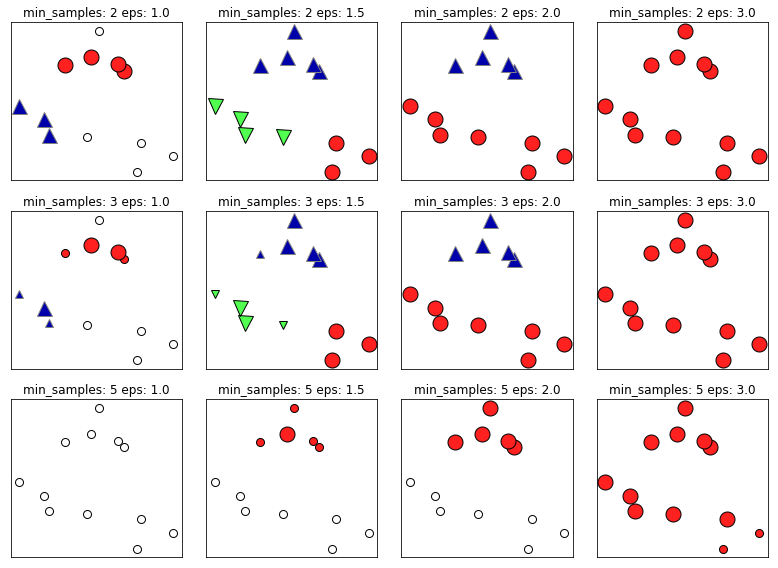

In [28]:
mglearn.plots.plot_dbscan()

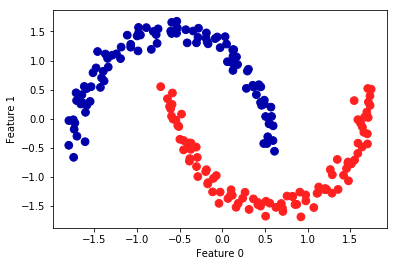

In [31]:
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

In [33]:
from sklearn.metrics import accuracy_score

# these two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# accuracy is zero, as none of the labels are the same
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# adjusted rand score is 1, as the clustering is exactly the same:
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00
